# ПРОЦЕСС ЭЛЕКТРОННО-ЛУЧЕВОЙ СВАРКИ

Задача: провести прогнозирование глубины (Depth) и ширины (Width) сварного шва в зависимости от параметров технологического процесса (IW, IF, VW, FP).
Регрессия

Целевая переменная:  

Depth - глубина сварного шва

Width - ширина сварного шва
 


Используемые признаки:

IW - величина сварочного тока

IF - ток фокусировки электронного пучка

VW - скорость сварки

FP — расстояние от поверхности образцов до электронно-оптической системы



In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

Загружаем датасет и смотрим его характеристики

In [4]:
df = pd.read_csv("ebw_data.csv")
df.head(5)

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


По первым строкам видно, что в датасете при одинаковых входных признаках имеются разные выходные значения

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
IW,72.0,45.666667,1.678363,43.00,44.00,45.50,47.00,49.00
IF,72.0,141.333333,5.145763,131.00,139.00,141.00,146.00,150.00
VW,72.0,8.638889,2.061078,4.50,8.00,9.00,10.00,12.00
FP,72.0,78.333333,21.493530,50.00,60.00,80.00,80.00,125.00
Depth,72.0,1.195556,0.225081,0.80,1.08,1.20,1.29,1.76
Width,72.0,1.970417,0.279040,1.68,1.76,1.84,2.05,2.60


<AxesSubplot: >

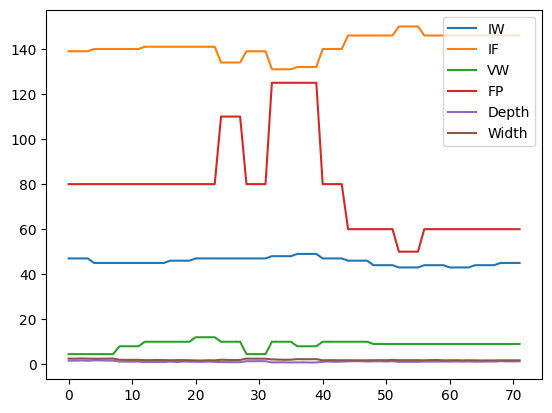

In [6]:
df.plot()

In [7]:
df.columns

Index(['IW', 'IF', 'VW', 'FP', 'Depth', 'Width'], dtype='object')

Строим парные графики и матрицу корреляции

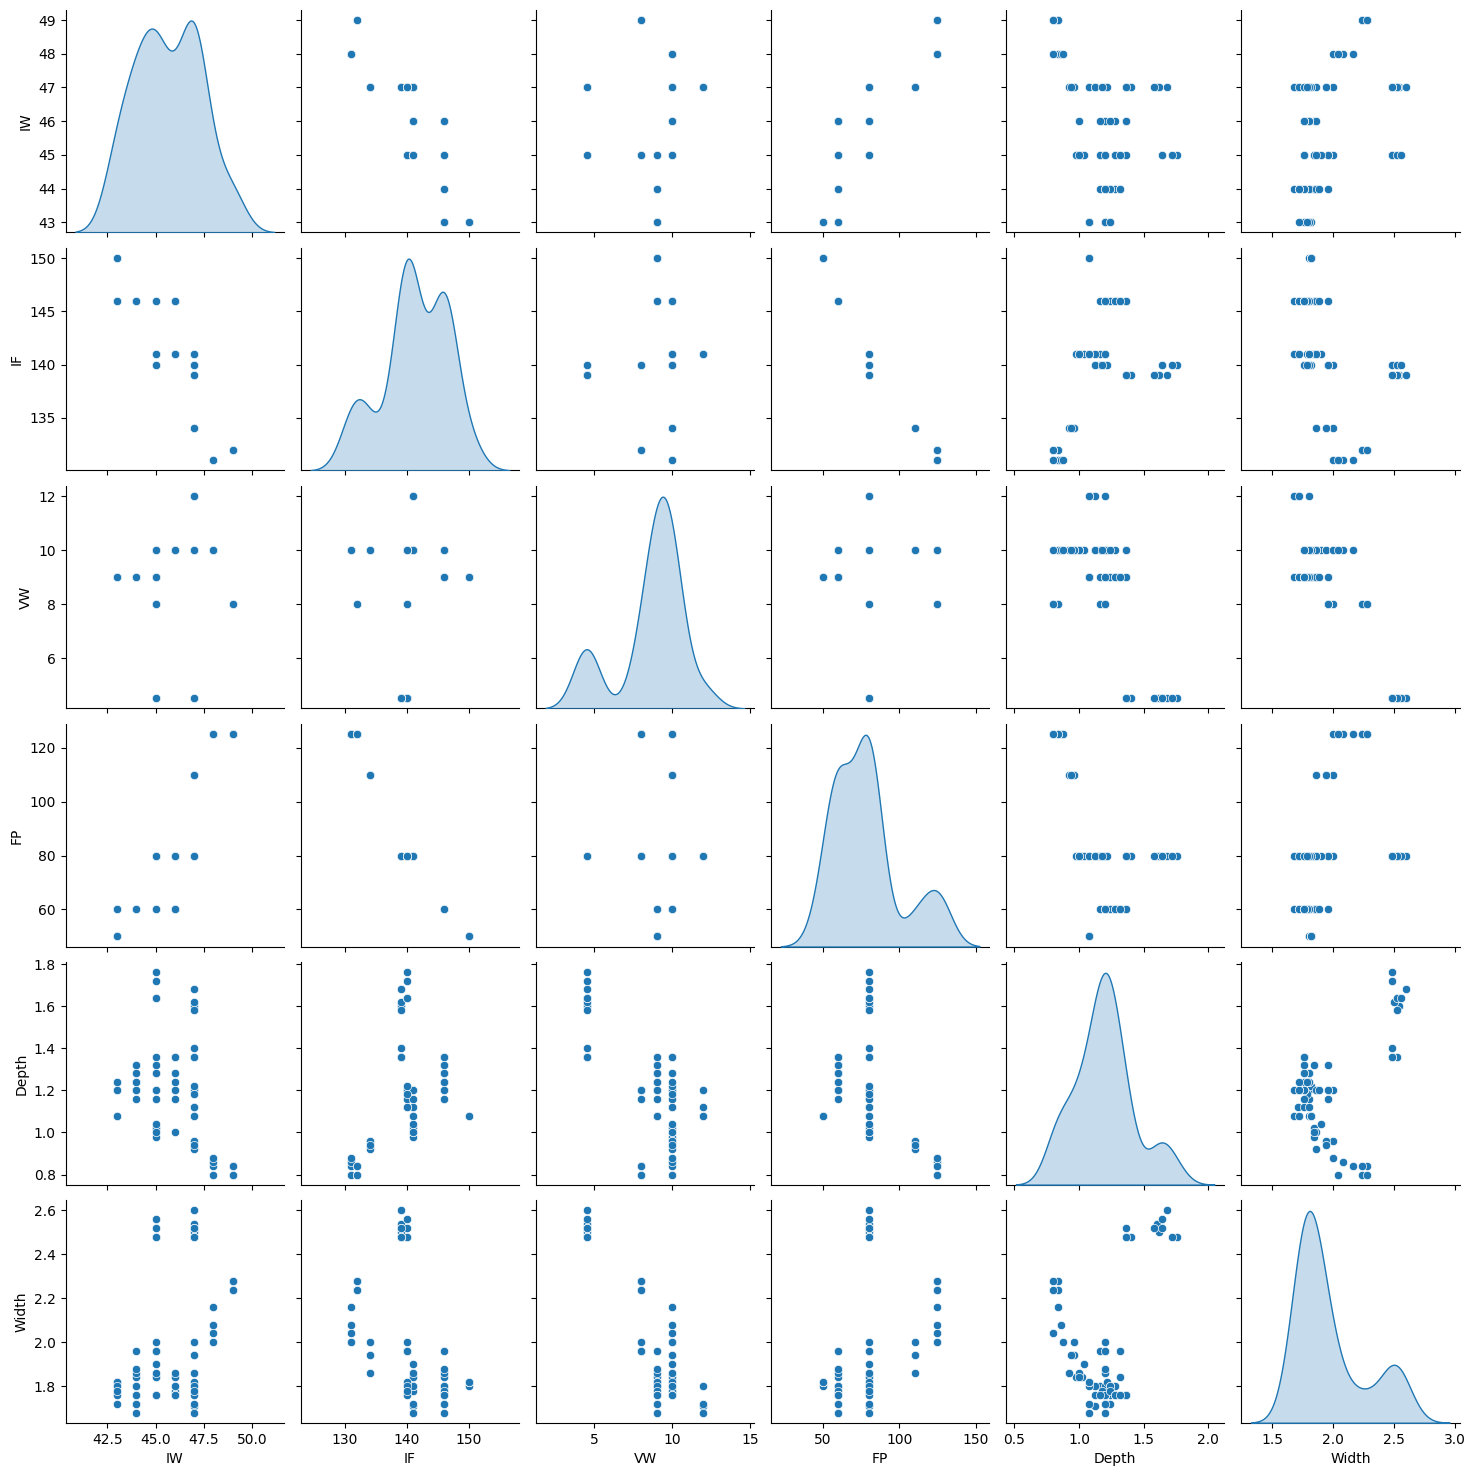

In [8]:
sns.pairplot(df, diag_kind='kde')

<AxesSubplot: >

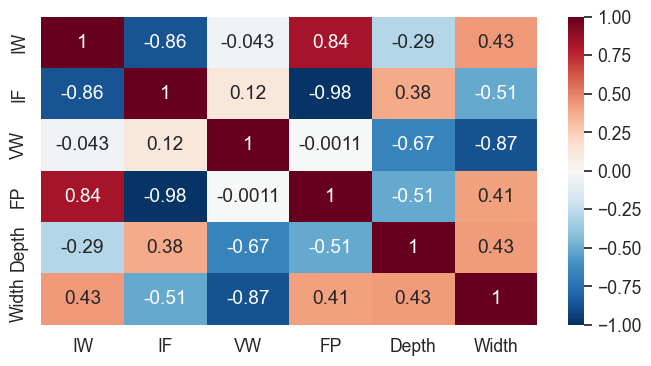

In [9]:
sns.set(font_scale=1.15)
plt.figure(figsize=(8,4))
sns.heatmap(
    df.corr(),        
    cmap='RdBu_r',
    annot=True, 
    vmin=-1, vmax=1)

Из матрицы корреляции видно, что наибольшая зависимость выходных параметров наблюдается от скорости сварки (корреляция отрицательная для обоих выходных значений). Построим линейные графики глубины и ширины шва от скорости сварки VW.
Наибольшая зависимость наблюдается между входными параметрами FP — расстояние от поверхности образцов до электронно-оптической системы и IF - ток фокусировки электронного пучка.
В связи с ограниченным объемом датасета и отсутствием эксперта из предметной области уменьшать размерность и исключать строки с повторяющимися значениями входных признаков не будем.

# Нормализация данных

Поскольку входные признаки сильно отличаются средними значениями и стандартным отклонением проведем нормализацию входных признаков для приведения к одному диапазону

In [10]:
minmax_scaler = MinMaxScaler()
dataset_norm = minmax_scaler. fit_transform(np.array(df[['IW', 'IF', 'VW', 'FP']]))

dataset_norm_df = pd.DataFrame(data = dataset_norm, columns =['IW', 'IF', 'VW', 'FP'])
dataset_norm_df

,IW,IF,VW,FP
0,0.666667,0.421053,0.0,0.400000
1,0.666667,0.421053,0.0,0.400000
2,0.666667,0.421053,0.0,0.400000
3,0.666667,0.421053,0.0,0.400000
4,0.333333,0.473684,0.0,0.400000
...,...,...,...,...
67,0.166667,0.789474,0.6,0.133333
68,0.333333,0.789474,0.6,0.133333
69,0.333333,0.789474,0.6,0.133333
70,0.333333,0.789474,0.6,0.133333


### Разделим данные на тренировочную и тестовую выборки

In [21]:
X = dataset_norm_df
X = df[['IW', 'IF', 'VW', 'FP']]
y = df[['Depth', 'Width']]
y_d = df[['Depth']]
y_w = df[['Width']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=47)
X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(X, y_d, test_size=0.20, random_state=47)
X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(X, y_w, test_size=0.20, random_state=47)

### Для решения задачи регрессии выберем следующие модели:
1. Линейная регрессия
2. Случайный лес
3. Нейросеть

Создадим датафрейм для сравнения метрик разных моделей

In [22]:
errors_df = pd.DataFrame(columns=['target_var','model_name','MAE','MSE','R2'])

def actual_and_predicted_plot(orig, predict, var, model_name):
    plt.figure(figsize=(17,5))
    plt.title(f'Тестовые и прогнозные значения: {model_name}')
    plt.plot(orig, label='Тест')
    plt.plot(predict, label='Прогноз')
    plt.legend(loc='best')
    plt.ylabel(var)
    plt.xlabel('Количество наблюдений')
    plt.show()

### 1. Линейная регрессия

Определим оптимальную степень полинома

In [23]:
def polynomial_regression_model(degree):
    pf=PolynomialFeatures(degree=degree)     
    X_train_poly = pf.fit_transform(X_train) 
    poly_model = MultiOutputRegressor(LinearRegression())
    poly_model.fit(X_train_poly, y_train)
    y_train_predict = poly_model.predict(X_train_poly)
    y_test_predict = poly_model.predict(pf.fit_transform(X_test))
    
    MSE = mean_squared_error(y_test, y_test_predict, multioutput='raw_values')
    MAE = mean_absolute_error(y_test, y_test_predict, multioutput='raw_values')
    R2 = r2_score(y_test, y_test_predict, multioutput='raw_values')
    
    print('Degree: ', degree)
    print('MSE Depth: %.3f,  Width: %.3f' % (MSE[0], MSE[1]))
    print('MAE Depth: %.3f,  Width: %.3f' % (MAE[0], MAE[1]))
    print('Coefficient of determination Depth: %.3f,  Width: %.3f' % (R2[0], R2[1]))


In [24]:
polynomial_regression_model(1)
polynomial_regression_model(2)
polynomial_regression_model(4)
polynomial_regression_model(8)

Degree:  1
MSE Depth: 0.010,  Width: 0.005
MAE Depth: 0.080,  Width: 0.062
Coefficient of determination Depth: 0.743,  Width: 0.912
Degree:  2
MSE Depth: 0.004,  Width: 0.003
MAE Depth: 0.052,  Width: 0.042
Coefficient of determination Depth: 0.893,  Width: 0.952
Degree:  4
MSE Depth: 0.004,  Width: 0.003
MAE Depth: 0.052,  Width: 0.042
Coefficient of determination Depth: 0.893,  Width: 0.952
Degree:  8
MSE Depth: 0.004,  Width: 0.003
MAE Depth: 0.052,  Width: 0.042
Coefficient of determination Depth: 0.893,  Width: 0.952


Вывод: увеличение степени полинома более 2 не дает повышения точности предсказания.
Оптимальной моделью линейной регрессии является модель второго порядка.

Создадим отдельные модели для глубины и ширины сварного шва и запишем их метрики в датафрейм



In [25]:
pf = PolynomialFeatures(degree=2)     
X_d_train_poly = pf.fit_transform(X_d_train) 
linear_model_Depth = LinearRegression()
linear_model_Depth.fit(X_d_train_poly, y_d_train)
y_test_d_predict = linear_model_Depth.predict(pf.fit_transform(X_d_test))

MAE_Depth = mean_absolute_error(y_d_test, y_test_d_predict)
MSE_Depth = mean_squared_error(y_d_test, y_test_d_predict)
R2_Depth = r2_score(y_d_test, y_test_d_predict)
rf_errors = pd.DataFrame({'model_name':'LinearRegression',
'target_var':['Глубина сварного шва, мм',],
'MAE':[MAE_Depth,],                          
'MSE':[MSE_Depth,],
'R2':[R2_Depth,]})
errors_df = pd.concat([errors_df, rf_errors], ignore_index=True)
errors_df

,target_var,model_name,MAE,MSE,R2
0,"Глубина сварного шва, мм",LinearRegression,0.052444,0.004127,0.892912


In [26]:
X_w_train_poly = pf.fit_transform(X_w_train) 
linear_model_Width = LinearRegression()
linear_model_Width.fit(X_w_train_poly, y_w_train)
y_test_w_predict = linear_model_Width.predict(pf.fit_transform(X_w_test))

MAE_Width = mean_absolute_error(y_w_test, y_test_w_predict)
MSE_Width = mean_squared_error(y_w_test, y_test_w_predict)
R2_Width = r2_score(y_w_test, y_test_w_predict)
rf_errors = pd.DataFrame({'model_name':'LinearRegression',
'target_var':['Ширина сварного шва, мм',],
'MAE':[MAE_Width,],                          
'MSE':[MSE_Width,],
'R2':[R2_Width,]})
errors_df = pd.concat([errors_df, rf_errors], ignore_index=True)
errors_df

,target_var,model_name,MAE,MSE,R2
0,"Глубина сварного шва, мм",LinearRegression,0.052444,0.004127,0.892912
1,"Ширина сварного шва, мм",LinearRegression,0.041667,0.002607,0.952366


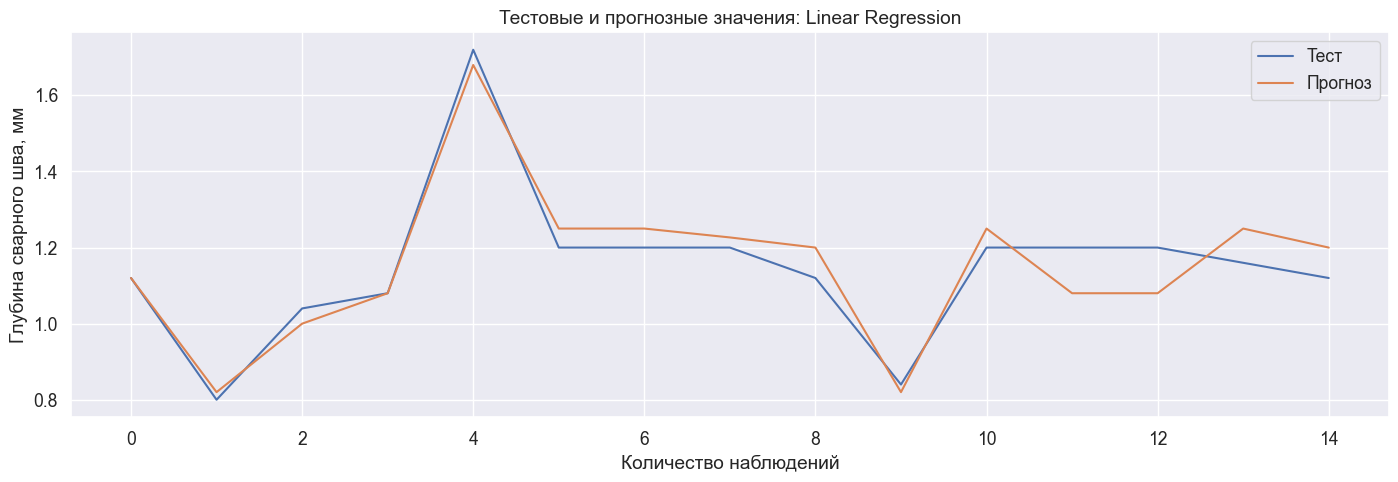

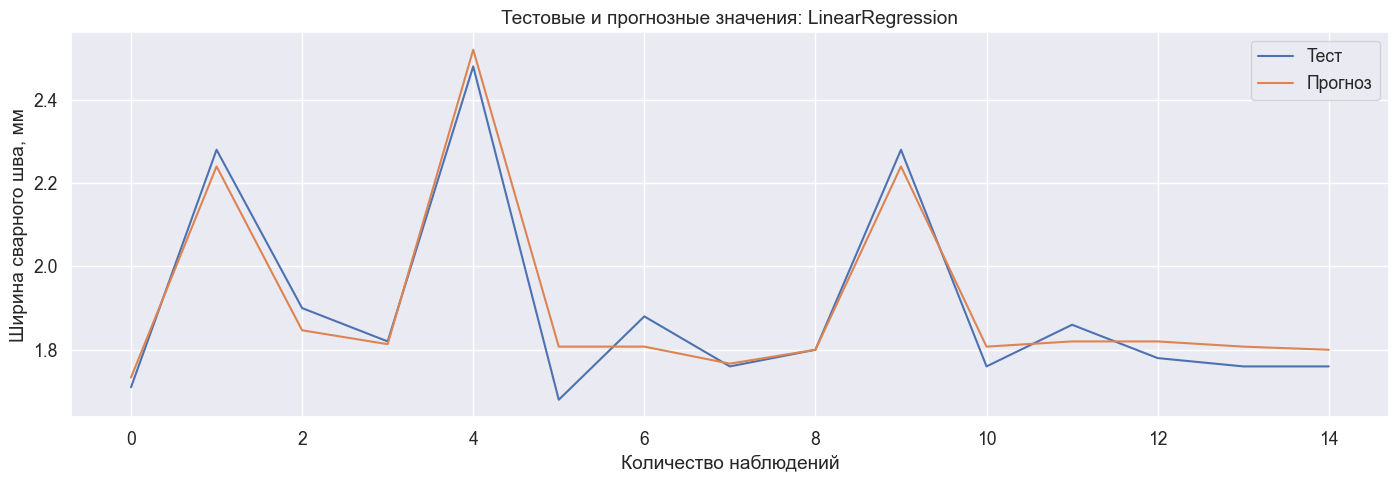

In [27]:
actual_and_predicted_plot(y_d_test.values,
linear_model_Depth.predict(pf.fit_transform(X_d_test)), 'Глубина сварного шва, мм',
'Linear Regression')
actual_and_predicted_plot(y_w_test.values,
linear_model_Width.predict(pf.fit_transform(X_w_test)), 'Ширина сварного шва, мм', 'LinearRegression')

### 2. Случайный лес

Используем GridSearchCV для автоматического подбора гиперпараметров модели

In [28]:
rf_model = RandomForestRegressor(random_state=35)
n_estimators = range(1, 100, 10)
max_depth = [1, 2, 3, 4]
max_features = ['sqrt', 'log2']
rf_model_params = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_features': max_features,
    'criterion':['squared_error']
}
GSCV_rf_model_Depth = GridSearchCV(rf_model, rf_model_params, cv=5, verbose=2)

GSCV_rf_model_Depth.fit(X_d_train, y_d_train.values.ravel())
# best_params
rf_model_Depth = GSCV_rf_model_Depth.best_estimator_

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=square

[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=61; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=61; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=61; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=61; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=71; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=71; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=71; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=71; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=71; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=81;

[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=51;

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, n_estimators=91; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, n_estimators=11; tota

[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=61; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=61; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=71; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=71; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=71; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=71; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=71; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=81; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=81; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=81;

In [29]:
MAE_Depth = mean_absolute_error(y_d_test,
rf_model_Depth.predict(X_d_test))
MSE_Depth = mean_squared_error(y_d_test,
rf_model_Depth.predict(X_d_test))
R2_Depth = r2_score(y_d_test,
rf_model_Depth.predict(X_d_test))
rf_errors = pd.DataFrame({'model_name':'RandomForestRegressor',
'target_var':['Глубина сварного шва, мм',],
'MAE':[MAE_Depth,],                          
'MSE':[MSE_Depth,],
'R2':[R2_Depth,]})
errors_df = pd.concat([errors_df, rf_errors], ignore_index=True)
errors_df

,target_var,model_name,MAE,MSE,R2
0,"Глубина сварного шва, мм",LinearRegression,0.052444,0.004127,0.892912
1,"Ширина сварного шва, мм",LinearRegression,0.041667,0.002607,0.952366
2,"Глубина сварного шва, мм",RandomForestRegressor,0.052360,0.003679,0.904536


In [30]:
GSCV_rf_model_Width = GridSearchCV(rf_model, rf_model_params, cv=5, verbose=2)

GSCV_rf_model_Width.fit(X_w_train, y_w_train.values.ravel())
# best_params
rf_model_Width = GSCV_rf_model_Width.best_estimator_

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=square

[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=61; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=61; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=61; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=71; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=71; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=71; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=71; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=71; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=81; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, n_estimators=81;

[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, max_features=log2, n_estimators=41;

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, n_estimators=91; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, n_estimators=91; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, n_estimators=91; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, n_estimators=91; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, n_estimators=91; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, n_estimators=1; tota

[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=61; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=61; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=61; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=61; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=61; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=71; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=sqrt, n_estimators=71;

In [31]:
MAE_Width = mean_absolute_error(y_w_test,
rf_model_Width.predict(X_w_test))
MSE_Width = mean_squared_error(y_w_test,
rf_model_Width.predict(X_w_test))
R2_Width = r2_score(y_w_test,
rf_model_Width.predict(X_w_test))
rf_errors = pd.DataFrame({'model_name':'RandomForestRegressor',
'target_var':['Ширина сварного шва, мм',],
'MAE':[MAE_Width,],                          
'MSE':[MSE_Width,],
'R2':[R2_Width,]})
errors_df = pd.concat([errors_df, rf_errors], ignore_index=True)
errors_df

,target_var,model_name,MAE,MSE,R2
0,"Глубина сварного шва, мм",LinearRegression,0.052444,0.004127,0.892912
1,"Ширина сварного шва, мм",LinearRegression,0.041667,0.002607,0.952366
2,"Глубина сварного шва, мм",RandomForestRegressor,0.052360,0.003679,0.904536
3,"Ширина сварного шва, мм",RandomForestRegressor,0.048183,0.003036,0.944529


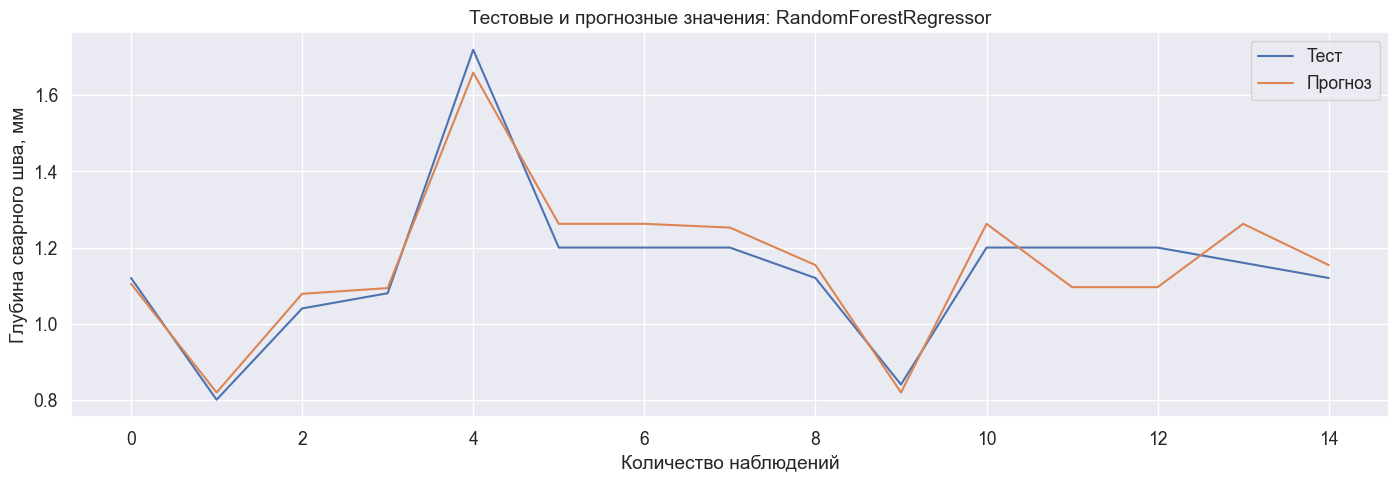

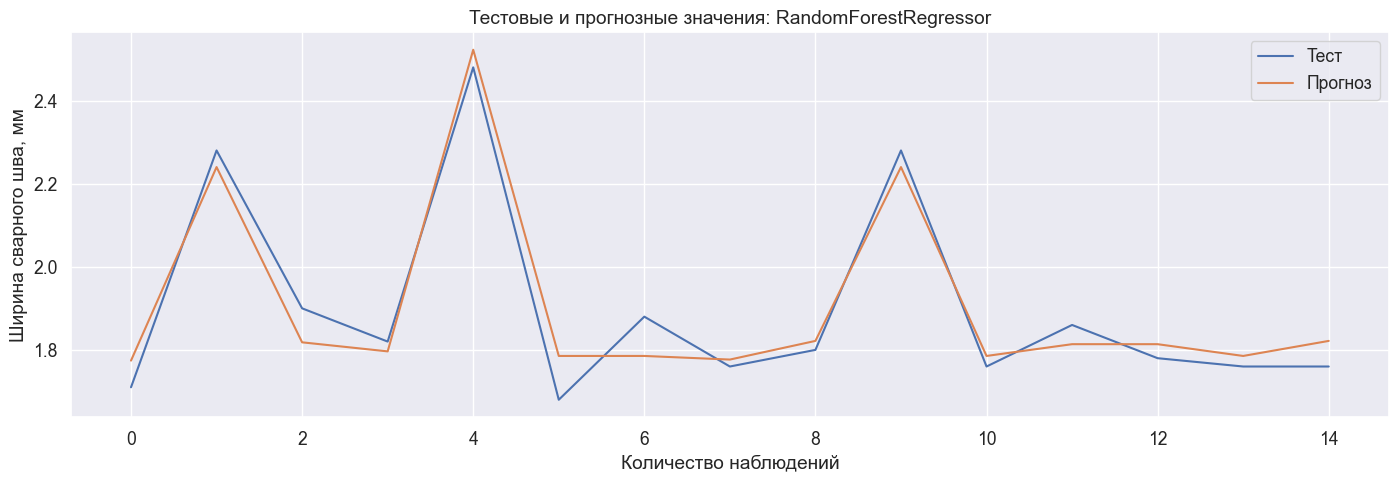

In [32]:
actual_and_predicted_plot(y_d_test.values,
rf_model_Depth.predict(X_d_test), 'Глубина сварного шва, мм',
'RandomForestRegressor')
actual_and_predicted_plot(y_w_test.values,
rf_model_Width.predict(X_w_test), 'Ширина сварного шва, мм', 'RandomForestRegressor')

---

### 3. Нейросеть

In [33]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [34]:
model_Depth = Sequential([
    Dense(500, activation='sigmoid', input_dim=4),
    Dense(100, activation='sigmoid'),
    Dense(1, activation='linear'),
])

model_Depth.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.01))

model_Depth.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               2500      
                                                                 
 dense_1 (Dense)             (None, 100)               50100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 52,701
Trainable params: 52,701
Non-trainable params: 0
_________________________________________________________________


CPU times: total: 2.56 s
Wall time: 1.87 s


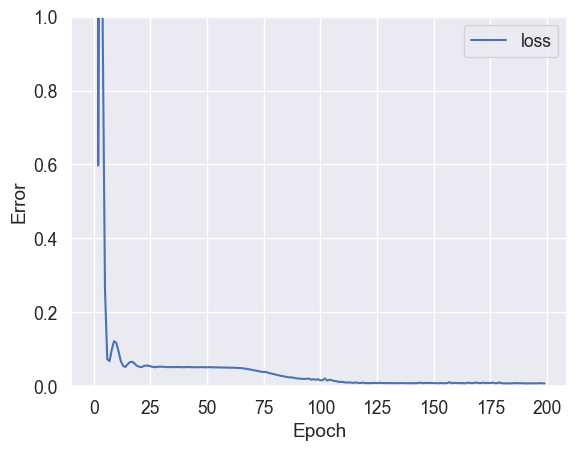

In [35]:
%%time
history = model_Depth.fit(
    X_d_train,
    y_d_train,
    epochs=200,
    verbose=0,
    validation_split=0)
plot_loss(history)

In [36]:
MAE_Depth = mean_absolute_error(y_d_test,
model_Depth.predict(X_d_test))
MSE_Depth = mean_squared_error(y_d_test,
model_Depth.predict(X_d_test))
R2_Depth = r2_score(y_d_test,
model_Depth.predict(X_d_test))
mlp_errors = pd.DataFrame({'model_name':'MLPRegressor',
'target_var':['Глубина сварного шва, мм',],
'MAE':[MAE_Depth,],                          
'MSE':[MSE_Depth,],
'R2':[R2_Depth,]})
errors_df = pd.concat([errors_df, mlp_errors], ignore_index=True)
errors_df

1/1 [==============================] - 0s 22ms/step


,target_var,model_name,MAE,MSE,R2
0,"Глубина сварного шва, мм",LinearRegression,0.052444,0.004127,0.892912
1,"Ширина сварного шва, мм",LinearRegression,0.041667,0.002607,0.952366
2,"Глубина сварного шва, мм",RandomForestRegressor,0.052360,0.003679,0.904536
3,"Ширина сварного шва, мм",RandomForestRegressor,0.048183,0.003036,0.944529
4,"Глубина сварного шва, мм",MLPRegressor,0.063226,0.006840,0.822520


In [37]:
model_Width = Sequential([
    Dense(200, activation='sigmoid', input_dim=4),
    Dense(1, activation='linear'),
])

model_Width.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.01))

model_Width.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 200)               1000      
                                                                 
 dense_4 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________


CPU times: total: 1.75 s
Wall time: 1.51 s


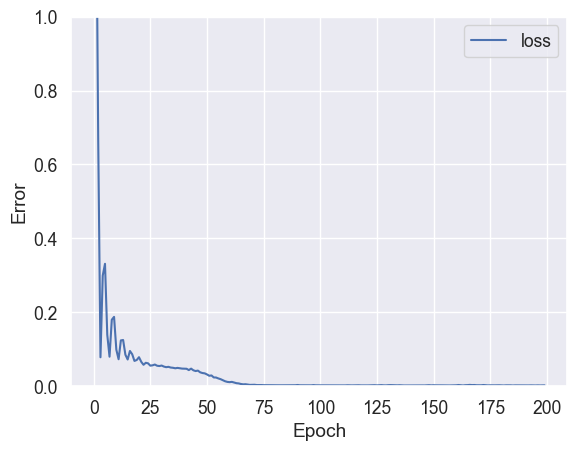

In [38]:
%%time
history = model_Width.fit(
    X_w_train,
    y_w_train,
    epochs=200,
    verbose=0,
    validation_split=0)
plot_loss(history)

In [163]:
MAE_Width = mean_absolute_error(y_w_test,
model_Width.predict(X_w_test))
MSE_Width = mean_squared_error(y_w_test,
model_Width.predict(X_w_test))
R2_Width = r2_score(y_w_test,
model_Width.predict(X_w_test))
mlp_errors = pd.DataFrame({'model_name':'MLPRegressor',
'target_var':['Ширина сварного шва, мм',],
'MAE':[MAE_Width,],                          
'MSE':[MSE_Width,],
'R2':[R2_Width,]})
errors_df = pd.concat([errors_df, mlp_errors], ignore_index=True)
errors_df

1/1 [==============================] - 0s 22ms/step


,target_var,model_name,MAE,MSE,R2
0,"Глубина сварного шва, мм",LinearRegression,0.052444,0.004127,0.892912
1,"Ширина сварного шва, мм",LinearRegression,0.041667,0.002607,0.952366
2,"Глубина сварного шва, мм",RandomForestRegressor,0.052360,0.003679,0.904536
3,"Ширина сварного шва, мм",RandomForestRegressor,0.048183,0.003036,0.944529
4,"Глубина сварного шва, мм",MLPRegressor,0.068811,0.006960,0.819409
5,"Ширина сварного шва, мм",MLPRegressor,0.062201,0.005080,0.907172


1/1 [==============================] - 0s 21ms/step


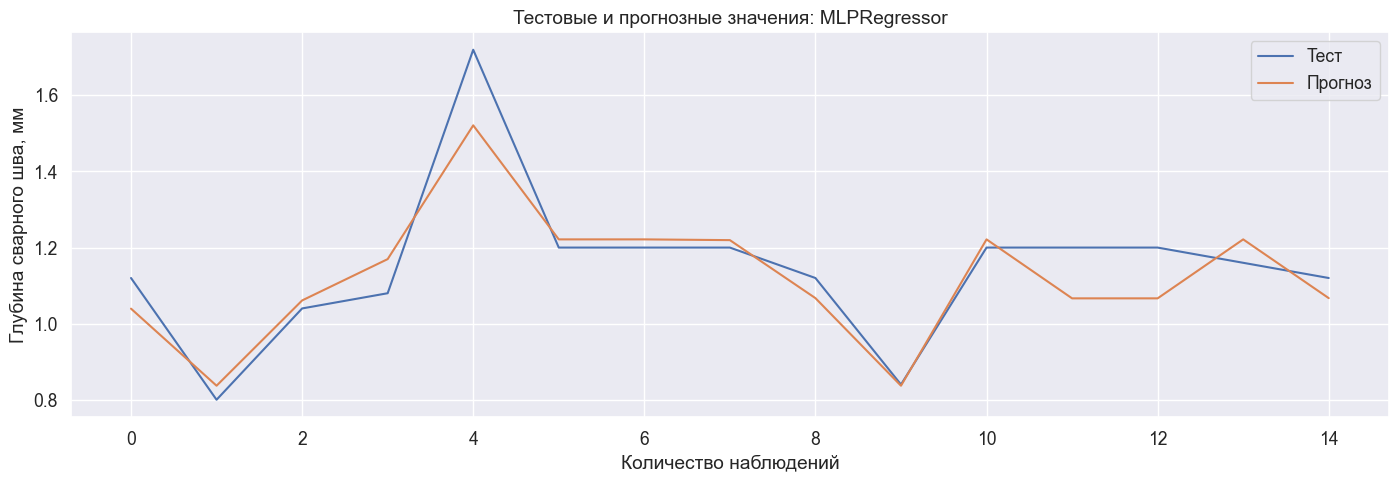

1/1 [==============================] - 0s 50ms/step


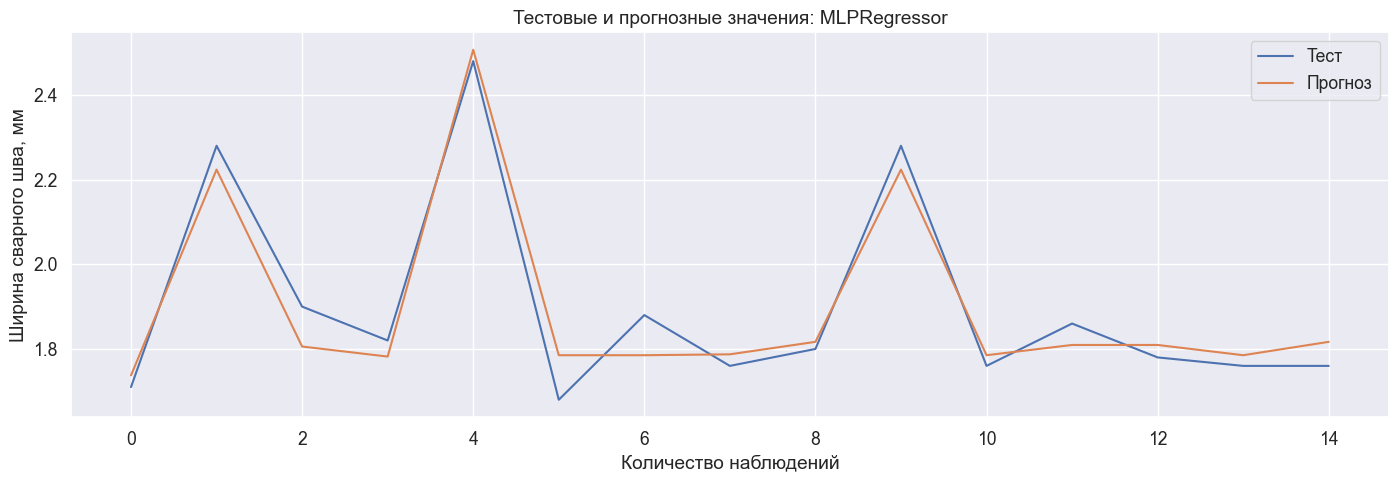

In [39]:
actual_and_predicted_plot(y_d_test.values,
model_Depth.predict(X_d_test), 'Глубина сварного шва, мм',
'MLPRegressor')
actual_and_predicted_plot(y_w_test.values,
model_Width.predict(X_w_test), 'Ширина сварного шва, мм', 'MLPRegressor')

---

### Вывод: 
Иcходя из полученных метрик выбираем лучшую модель. Для предсказания глубины сварного шва - rf_model_Depth использующая алгоритм RandomForestRegressor.  Для предсказания ширины сварного шва - linear_model_Width, использующая алгоритм LinearRegression 

---